## Test different training ideas

In [42]:
from fastai.vision import *
from datasets import SemanticSegmentationData

In [43]:
defaults.device = torch.device("cpu")

In [44]:
defaults.device

device(type='cpu')

In [45]:
USERSPACE = Path(os.environ["SENSEI_USERSPACE_SELF"])

In [46]:
PATH, CODES, TRAIN, VALID, TEST = USERSPACE/"siim", "codes.txt", "train.txt", None, "test.txt"
segdata = SemanticSegmentationData(PATH, CODES, TRAIN, VALID, TEST, None, bs=64, size=224)

In [47]:
data = segdata.get_data().normalize(imagenet_stats)

In [48]:
data

ImageDataBunch;

Train: LabelList (9638 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /trainman-mount/trainman-storage-ac168968-e641-4146-85da-cf960ab9e0bc/siim;

Valid: LabelList (2409 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /trainman-mount/trainman-storage-ac168968-e641-4146-85da-cf960ab9e0bc/siim;

Test: LabelList (3205 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /trainm

In [65]:
x = torch.rand((1,2,12,12))

In [69]:
x[:, 1, :, :].size()

torch.Size([1, 12, 12])

### model

In [49]:
learn = unet_learner(data, arch = models.resnet34, pretrained = True)

In [70]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

### loss

In [50]:
from losses import *

In [51]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [52]:
learn.loss_func = lovasz_softmax

### metric

In [53]:
from metrics import *

In [54]:
# void_code = np.where(learn.data.classes == "Void")[0].item()
# learn.metrics = [partial(foreground_acc, void_code=void_code)]
learn.metrics = [dice]

In [55]:
learn.metrics

[<function fastai.metrics.dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False, eps: float = 1e-08) -> <function NewType.<locals>.new_type at 0x7ff49ddbb950>>]

### custom scheduling

In [56]:
from fastai.callbacks.general_sched import *

In [57]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks = [cb for cb in learn.callbacks if cb.__class__ != GeneralScheduler]
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [58]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr/10)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks = [cb for cb in learn.callbacks if cb.__class__ != GeneralScheduler]
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

### opt_func

In [59]:
from optimizers import *

In [60]:
opt = "ranger"

In [61]:
alpha=0.99; mom=0.9; eps=1e-8; lr=3e-2; epochs=5; ann_start=0.2

if   opt=='adam' : opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
elif opt=='radam' : opt_func = partial(RAdam, betas=(mom,alpha), eps=eps)
elif opt=='novograd' : opt_func = partial(Novograd, betas=(mom,alpha), eps=eps)
elif opt=='rms'  : opt_func = partial(optim.RMSprop, alpha=alpha, eps=eps)
elif opt=='sgd'  : opt_func = partial(optim.SGD, momentum=mom)
elif opt=='ranger'  : opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
elif opt=='ralamb'  : opt_func = partial(Ralamb,  betas=(mom,alpha), eps=eps)
elif opt=='rangerlars'  : opt_func = partial(RangerLars,  betas=(mom,alpha), eps=eps)
elif opt=='lookahead'  : opt_func = partial(LookaheadAdam, betas=(mom,alpha), eps=eps)
elif opt=='lamb'  : opt_func = partial(Lamb, betas=(mom,alpha), eps=eps)

In [62]:
learn.opt_func = opt_func

In [63]:
learn.fit_one_cycle(epochs, lr, div_factor=5, pct_start=0.3)
learn.freeze_to(-1)
learn.fit_one_cycle(epochs, slice(lr/4,lr/2), div_factor=5, pct_start=0.3)
learn.unfreeze()
learn.fit_one_cycle(epochs, slice(lr/10,lr/4), div_factor=5, pct_start=0.3)

epoch,train_loss,valid_loss,dice,time


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", 

KeyboardInterrupt: 

In [33]:
%debug

> /opt/conda/lib/python3.7/site-packages/torch/nn/functional.py(1790)nll_loss()
   1788                          .format(input.size(0), target.size(0)))
   1789     if dim == 2:
-> 1790         ret = torch._C._nn.nll_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index)
   1791     elif dim == 4:
   1792         ret = torch._C._nn.nll_loss2d(input, target, weight, _Reduction.get_enum(reduction), ignore_index)



ipdb>  target


tensor([0, 0, 0,  ..., 0, 0, 0])


ipdb>  target.unique(


*** SyntaxError: unexpected EOF while parsing


ipdb>  target.unique()


tensor([  1, 191,  64, 255, 128,   0])


ipdb>  u


> /opt/conda/lib/python3.7/site-packages/torch/nn/functional.py(1970)cross_entropy()
   1968     if size_average is not None or reduce is not None:
   1969         reduction = _Reduction.legacy_get_string(size_average, reduce)
-> 1970     return nll_loss(log_softmax(input, 1), target, weight, None, ignore_index, None, reduction)
   1971 
   1972 



ipdb>  u


> /opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py(904)forward()
    902     def forward(self, input, target):
    903         return F.cross_entropy(input, target, weight=self.weight,
--> 904                                ignore_index=self.ignore_index, reduction=self.reduction)
    905 
    906 



ipdb>  exit


In [314]:
fit_with_annealing(learn, epochs, lr, ann_start)
learn.freeze_to(-1)
fit_with_annealing(learn, epochs, lr, ann_start)
learn.unfreeze()
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,foreground_acc,time
0,1183.685303,1.529367,0.637554,00:13
1,421.511414,3.204963,0.433765,00:15
2,193.812332,1.726429,0.474264,00:17
3,98.031609,1.702010,0.481464,00:14
4,52.032322,1.690924,0.489333,00:15


epoch,train_loss,valid_loss,foreground_acc,time
0,1.699577,1.679598,0.496688,00:14
1,1.690916,1.625713,0.539728,00:13
2,1.641744,1.542699,0.560947,00:15
3,1.589461,1.470916,0.584032,00:15
4,1.541020,1.452401,0.590949,00:16


epoch,train_loss,valid_loss,foreground_acc,time


RuntimeError: CUDA out of memory. Tried to allocate 75.88 MiB (GPU 0; 15.75 GiB total capacity; 6.36 GiB already allocated; 51.88 MiB free; 109.08 MiB cached)

In [ ]:
for cb in learn.callbacks: print(cb.__class__)

### more schedulars

In [286]:
def flat_phases(num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr/10)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    return phases

In [294]:
ph1, ph2 = flat_phases(epochs, lr, 0.2)

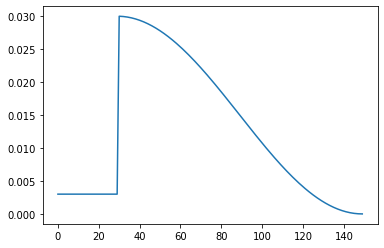

In [295]:
steps = []
for ph in [ph1, ph2]:
    ph.scheds["lr"].restart()
    steps += [ph.scheds["lr"].step() for i in range(ph.scheds["lr"].n_iter)]
plt.plot(steps)

### export

In [20]:
learn.load("mybestmodel");
learn.export("modelexport")
export = torch.load(PATH/"modelexport")
model = export["model"]